In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [3]:
import sklearn.datasets
import sklearn.model_selection

In [4]:
numeros = sklearn.datasets.load_digits()
imagenes = numeros['images']  # Hay 1797 digitos representados en imagenes 8x8
n_imagenes = len(imagenes)
X = imagenes.reshape((n_imagenes, -1)) # para volver a tener los datos como imagen basta hacer data.reshape((n_imagenes, 8, 8))
#X=imagenes
Y = numeros['target']
print(np.shape(X), np.shape(Y))
print(Y[:10])

(1797, 64) (1797,)
[0 1 2 3 4 5 6 7 8 9]


In [5]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.5)

In [6]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = (scaler.transform(X_test))
#conversion to pytorch tensor and adding a 1 dimension with unsqueeze
X_train_t = torch.from_numpy(X_train.reshape((len(X_train), 8, 8))).unsqueeze(1)
X_test_t = torch.from_numpy(X_test.reshape((len(X_test), 8, 8))).unsqueeze(1)

In [7]:
print(np.shape(X_train_t[0]))
print(X_train_t.size())

torch.Size([1, 8, 8])
torch.Size([898, 1, 8, 8])


(898, 64)


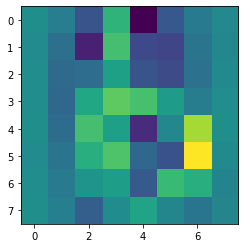

In [8]:
print(np.shape(X_train))
plt.imshow(X_train.reshape((898, 8, 8))[0])

In [15]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        #input1, out:15
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 15, kernel_size=8, stride=1),
            torch.nn.ReLU(True),
            # out:15, out7
            torch.nn.Conv2d(15,1,kernel_size=4, stride=1,padding=5),
            torch.nn.ReLU(True))
        self.decoder = torch.nn.Sequential(             
            torch.nn.ConvTranspose2d(1,15,kernel_size=4,padding=5),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(15,1,kernel_size=8, stride=1),
            torch.nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
auto = Autoencoder()
print(auto)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 15, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(15, 1, kernel_size=(4, 4), stride=(1, 1), padding=(5, 5))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 15, kernel_size=(4, 4), stride=(1, 1), padding=(5, 5))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(15, 1, kernel_size=(8, 8), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
)


In [16]:
# inicializa modelo, loss y optimizador
num_epochs = 200
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1E-3)
loss_values = np.zeros(num_epochs)

In [17]:
# entrenamiento
for epoch in range(num_epochs):
    output = model(X_train_t.float())
    loss = distance(output, X_train_t.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_values[epoch] = loss.item()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/200], loss:0.9424
epoch [2/200], loss:0.9406
epoch [3/200], loss:0.9391
epoch [4/200], loss:0.9379
epoch [5/200], loss:0.9370
epoch [6/200], loss:0.9366
epoch [7/200], loss:0.9361
epoch [8/200], loss:0.9353
epoch [9/200], loss:0.9336
epoch [10/200], loss:0.9310
epoch [11/200], loss:0.9278
epoch [12/200], loss:0.9234
epoch [13/200], loss:0.9173
epoch [14/200], loss:0.9095
epoch [15/200], loss:0.9006
epoch [16/200], loss:0.8922
epoch [17/200], loss:0.8864
epoch [18/200], loss:0.8834
epoch [19/200], loss:0.8803
epoch [20/200], loss:0.8743
epoch [21/200], loss:0.8674
epoch [22/200], loss:0.8618
epoch [23/200], loss:0.8574
epoch [24/200], loss:0.8528
epoch [25/200], loss:0.8473
epoch [26/200], loss:0.8416
epoch [27/200], loss:0.8361
epoch [28/200], loss:0.8308
epoch [29/200], loss:0.8253
epoch [30/200], loss:0.8197
epoch [31/200], loss:0.8144
epoch [32/200], loss:0.8097
epoch [33/200], loss:0.8051
epoch [34/200], loss:0.8004
epoch [35/200], loss:0.7964
epoch [36/200], loss:0.7926
e

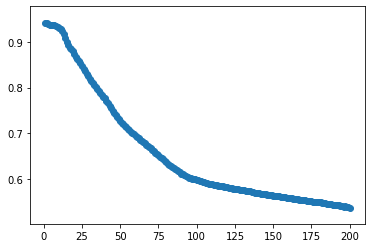

In [18]:
plt.scatter(np.arange(1,num_epochs+1),loss_values)

In [19]:
x_transform = model(X_train_t.float())
latent_space = model.encoder(X_train_t.float())
print(x_transform.size())
print(latent_space.size())

torch.Size([898, 1, 8, 8])
torch.Size([898, 1, 8, 8])


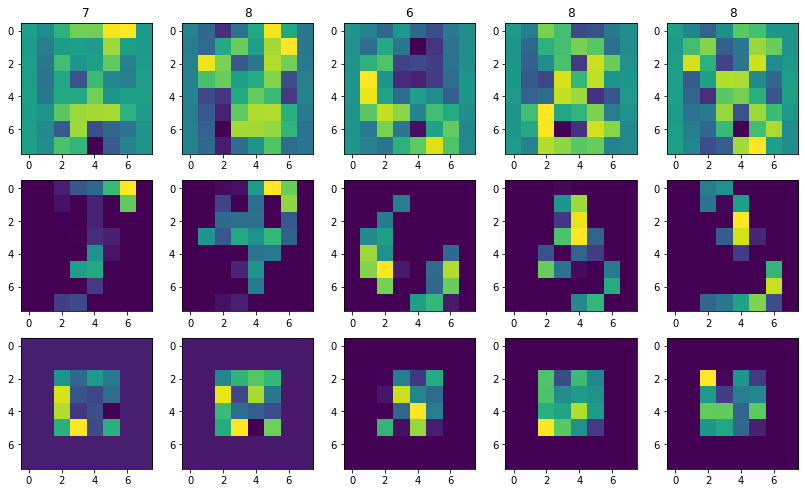

In [20]:
# muestra los resultados de las cuatro capas de convolucion
plt.figure(figsize=(14,14))
offset = 16
for i in range(5):
    plt.subplot(5,5,i+1) #imagenes originales
    plt.imshow(X_train_t[i+offset][0].detach().numpy())
    plt.title(Y_train[i+offset])
    
    j=0 # las imagenes reconstruidas por el autoencoder
    plt.subplot(5,5,(i+1)+5*(j+1))
    plt.imshow(x_transform[i+offset][0].detach().numpy())
    
    j=1 # una de las capas de la representacion latente
    plt.subplot(5,5,(i+1)+5*(j+1))
    plt.imshow(latent_space[i+offset][0].detach().numpy())
